<a href="https://colab.research.google.com/github/mervenurerdogan/LungCancerCustomModel2/blob/main/LUNGSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.4 MB/s 
     |████████████████████████████████| 1.2 MB 32.0 MB/s 
     |████████████████████████████████| 188 kB 42.0 MB/s 
     |████████████████████████████████| 60 kB 813 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *

In [3]:
from fastai.vision.all import *

In [4]:
path=Path('/content/gdrive/MyDrive/BINARY')

In [5]:
train_fnames = get_image_files(path)

In [6]:
dblock=DataBlock(blocks=(ImageBlock(cls=PILImage),CategoryBlock),
                 splitter=RandomSplitter(valid_pct=0.25,seed=41),
                 get_y=parent_label,
                 item_tfms=Resize(512,method='squish'),
                 batch_tfms=[*aug_transforms(size=256, max_warp=0), Normalize.from_stats(*imagenet_stats)]
                 
                 
)

In [7]:
dls=dblock.dataloaders(train_fnames)

In [8]:
dls.c,len(dls.train_ds),len(dls.valid_ds)

(2, 510, 170)

In [9]:
dls.vocab

['CANCER', 'NORMAL']

In [10]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.ReLU(inplace=False)
    )

In [11]:
def max_pool():
    return nn.MaxPool2d(2,stride=2)

In [12]:
class ResBlock(Module):
    def __init__(self,nf):
        self.conv1=ConvLayer(nf,nf)
        self.conv2=ConvLayer(nf,nf)
    def forward(self,x):
        return x+self.conv2(self.conv1(x))

In [13]:
def conv_and_res(ni,nf):
    return nn.Sequential(
        conv_block(ni,nf),
        ResBlock(nf)
    )

In [14]:
model=nn.Sequential(
    conv_block(3,8),
    max_pool(),
    conv_and_res(8,16),
    max_pool(),
    conv_block(16,32),
    max_pool(),
    conv_and_res(32,64),
    max_pool(),
    conv_and_res(64,32),
    nn.Dropout(0.25),
    conv_block(32,16),
    max_pool(),
    conv_and_res(16,8),
    conv_block(8,2),
    Flatten()

)

In [15]:
learn=Learner(dls,model,metrics=accuracy)

In [16]:
print(learn.summary())

Sequential (Input shape: 64 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8 x 256 x 256  
Conv2d                                    216        True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 128 x 128  
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 16 x 128 x 128 
Conv2d                                    1152       True      
BatchNorm2d                               32         True      
ReLU                                                           
Conv2d                                    2304       True      
BatchNorm2d                               32         True      
ReLU                               

SuggestedLRs(valley=0.0030199517495930195)

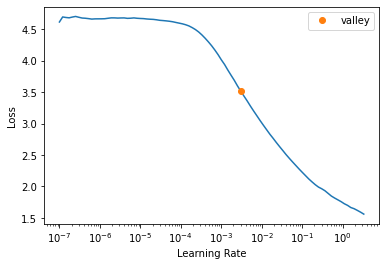

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(30, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.554575,4.765343,0.000000,00:18
1,4.317188,4.620765,0.535294,00:10
2,3.829925,4.195485,0.647059,00:10
3,3.218977,2.624000,0.694118,00:10
4,2.668887,1.116758,0.782353,00:10
5,2.217806,0.469327,0.841176,00:10
6,1.851670,0.262036,0.941176,00:10
7,1.552189,0.269751,0.952941,00:10
8,1.313628,0.302897,0.911765,00:10
9,1.123145,0.259596,0.952941,00:10


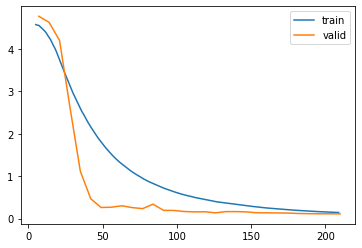

In [19]:
learn.recorder.plot_loss()

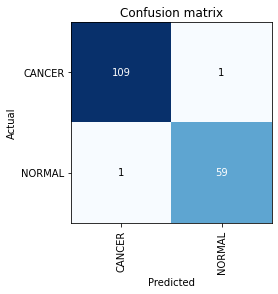

In [20]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [21]:
print("Number of examples in testing:", len(dls.valid_ds))

Number of examples in testing: 170


In [22]:
preds, targs = learn.tta()
accuracy(preds, targs).item()

0.9941176176071167

In [23]:
interp.most_confused()

[('CANCER', 'NORMAL', 1), ('NORMAL', 'CANCER', 1)]

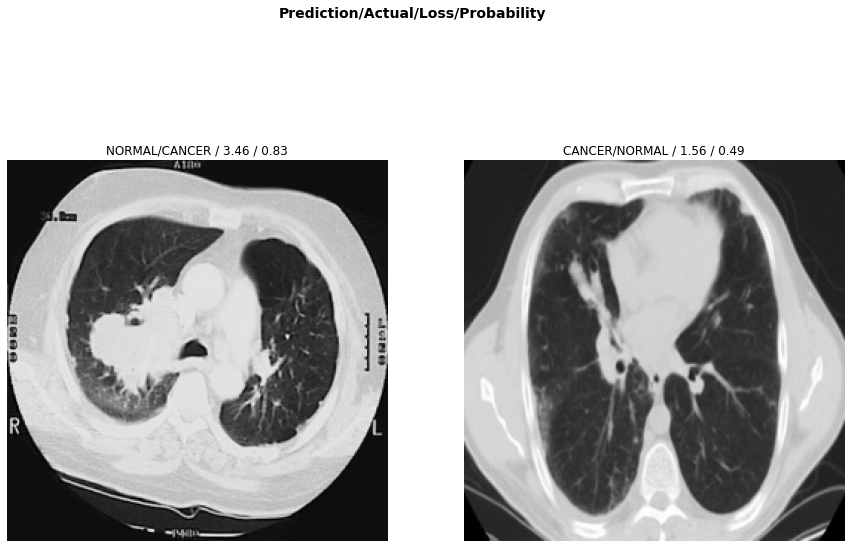

In [24]:
interp.plot_top_losses(2, figsize=(15,10))

In [25]:
interp.print_classification_report()

              precision    recall  f1-score   support

      CANCER       0.99      0.99      0.99       110
      NORMAL       0.98      0.98      0.98        60

    accuracy                           0.99       170
   macro avg       0.99      0.99      0.99       170
weighted avg       0.99      0.99      0.99       170



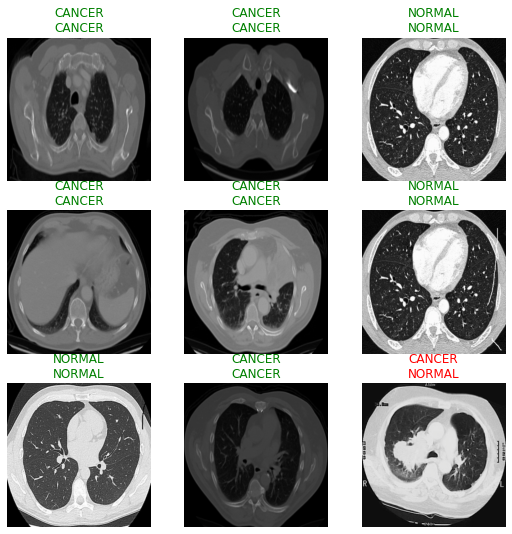

In [29]:
learn.show_results()

In [47]:
losses,idxs = interp.top_losses(2)
print(idxs)

TensorBase([110, 154])


In [48]:
dls.valid_ds.items[110]

Path('/content/gdrive/MyDrive/BINARY/CANCER/CANCER (291).png')

In [49]:
dls.valid_ds.items[154]

Path('/content/gdrive/MyDrive/BINARY/NORMAL/NORMAL (205).png')

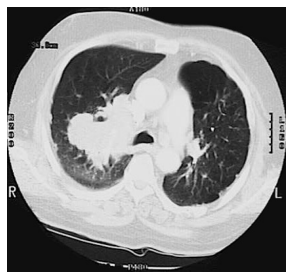

In [58]:
img = PILImage.create('/content/gdrive/MyDrive/BINARY/CANCER/CANCER (291).png')
img.show()

In [59]:
is_cancer,_,probs = learn.predict(img)
print(f"Is this a CANCER?: {is_cancer}")
print(f"Probability it's a CANCER: {probs[0].item():.2f}")

Is this a CANCER?: NORMAL
Probability it's a CANCER: 0.03


In [60]:
learn.predict(img)

('NORMAL',
 TensorBase(1),
 TensorBase([0.0314, 0.8327, 0.0009, 0.0009, 0.0012, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0010, 0.0020, 0.0009, 0.0009, 0.0009, 0.0009, 0.0011, 0.0009, 0.0009,
         0.0022, 0.0029, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0010, 0.0018, 0.0048, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0011, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009,
         0.0009, 0.0009, 0.0009, 0.0009, 0.0011, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0009, 0.0011, 0.0010, 0.0009, 0.0009, 0.0009, 0.0009, 0.0012, 0.0009, 0.0009, 0.0011, 0.0013, 0.0012,
         0.0009, 0.0010, 0.0013, 0.0009, 0.0009, 0.0009, 0.0009, 0.0011, 0.0009, 0.0009, 0.0017, 0.0014, 0.0011, 0.0013, 0.0015, 0.0012, 0.0009, 0.0009, 0.0013, 0.0010, 0.0011, 0.0012, 0.0011, 0.0012,
         0.0009, 0.0009, 0.0010, 0.0009, 0.0011, 0.0014, 0.0012, 0.0013, 0.0009, 0.0009, 0.0009, 0.0009, 0.0012, 0.0011, 0.0013, 0.0012, 0.0011, 0.0009, 0.0017, 0.00

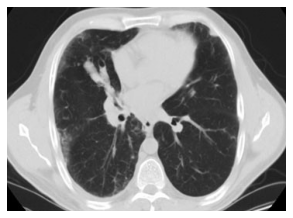

In [55]:
img = PILImage.create('/content/gdrive/MyDrive/BINARY/NORMAL/NORMAL (205).png')
img.show()

In [56]:
is_cancer,_,probs = learn.predict(img)
print(f"Is this a CANCER?: {is_cancer}")
print(f"Probability it's a CANCER: {probs[0].item():.2f}")

Is this a CANCER?: CANCER
Probability it's a CANCER: 0.49


In [67]:
btn=widgets.FileUpload() 
btn

FileUpload(value={}, description='Upload')

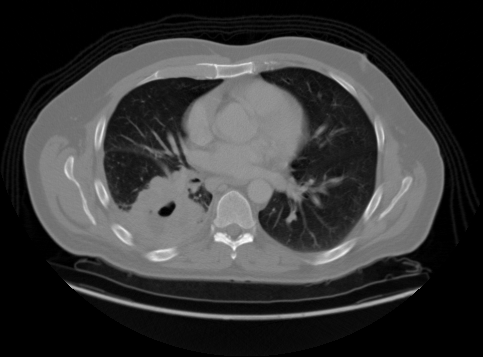

In [70]:
img_out=PILImage.create(btn.data[-1])
img_out

In [71]:
is_cancer,_,probs = learn.predict(img_out)
print(f"Is this a CANCER?: {is_cancer}")
print(f"Probability it's a CANCER: {probs[0].item():.2f}")

Is this a CANCER?: CANCER
Probability it's a CANCER: 0.95


In [72]:
learn.export('NewDATABinaryCustomModel_Export.pkl')

In [73]:
learn.save('NewDATABinaryCustomModel')

Path('models/NewDATABinaryCustomModel.pth')